##  Part 1. Matrix Factorization

- MovieLens 데이터셋 활용하기
- SVD를 직접 구현하고, 적절한 k값 찾기
- matrix factorization을 간단히 할 수 있는 파이썬 라이브러리


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
from math import sqrt
from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## Dataset 불러오기

In [3]:
# 각자 작업 환경에 맞는 경로를 지정해주세요. Google Colab과 Jupyter환경에서 경로가 다를 수 있습니다.
path = '/content/drive/MyDrive/Colab Notebooks/recsys/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [4]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


### Sparse Matrix 만들기

In [5]:
sparse_matrix = train_df.groupby('movieId').apply(lambda x: pd.Series(x['rating'].values, index=x['userId'])).unstack()
sparse_matrix.index.name = 'movieId'

sparse_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,NaN,2.5,NaN,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,NaN,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# fill sparse matrix with average of movie ratings
sparse_matrix_withmovie = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=1)

# fill sparse matrix with average of user ratings
sparse_matrix_withuser = sparse_matrix.apply(lambda x: x.fillna(x.mean()), axis=0)

In [ ]:
sparse_matrix_withmovie.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.893491,3.893491,3.893491,3.893491,4.000000,3.893491,4.500000,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,2.500000,3.893491,3.893491,3.500000,4.000000,3.893491,3.500000,3.893491,3.893491,3.893491,3.893491,3.893491,3.000000,3.893491,3.893491,3.893491,3.893491,3.000000,3.000000,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,...,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,3.893491,4.000000,3.893491,3.893491,3.893491,3.893491,5.000000,3.893491,3.893491,5.000000,3.893491,3.893491,4.00,3.893491,3.893491,3.893491,3.893491,3.893491,4.000000,3.893491,3.893491,3.000000,3.893491,4.000000,3.893491,4.000000,3.000000,4.000000,2.500000,3.893491,2.500000,3.893491,5.000000
2,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,4.000000,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.000000,3.000000,3.000000,3.500000,3.396341,3.396341,3.396341,3.396341,3.396341,4.000000,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,...,3.396341,3.396341,4.500000,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,3.396341,2.50,3.396341,4.000000,3.396341,4.000000,3.396341,3.396341,3.396341,3.396341,2.500000,4.000000,3.396341,4.000000,3.396341,3.396341,3.500000,3.396341,3.396341,2.000000,3.396341,3.396341
3,4.000000,3.454545,3.454545,3.454545,3.454545,5.000000,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.000000,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.000000,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,...,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.000000,3.454545,3.00,3.454545,3.454545,3.454545,4.000000,3.454545,3.454545,3.454545,3.454545,1.500000,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545,3.454545
4,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,3.000000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,...,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.25,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000,2.250000
5,3.039474,3.039474,3.039474,3.039474,3.039474,5.000000,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.000000,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,...,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,2.00,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,2.500000,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474,3.039474


In [ ]:
sparse_matrix_withuser.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.320652,3.94,2.516667,3.631868,4.000000,3.504132,4.500000,3.486486,3.1,3.292035,3.758621,4.333333,3.56,3.45,2.500000,3.723684,4.195402,3.500000,4.000000,3.60396,3.500000,2.6,3.618557,3.659341,4.785714,3.3125,3.000000,3.00547,4.19697,4.711538,3.911765,3.000000,3.000000,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.192308,4.0,3.033333,2.916667,3.589147,3.934783,4.000000,3.534286,4.370968,4.054348,3.255556,5.000000,4.339623,4.328025,5.000000,3.217391,3.878788,4.000000,3.26087,3.653333,3.23494,3.860963,4.210526,4.000000,3.980337,3.764706,3.000000,2.991468,4.000000,3.473684,4.000000,3.000000,4.000000,2.500000,3.772414,2.500000,3.275862,5.000000
2,4.320652,3.94,2.516667,3.631868,3.636364,3.504132,3.247967,4.000000,3.1,3.292035,3.758621,4.333333,3.56,3.45,3.422018,3.723684,4.195402,3.000000,3.000000,3.00000,3.500000,2.6,3.618557,3.659341,4.785714,3.3125,4.000000,3.00547,4.19697,4.711538,3.911765,3.759036,3.851562,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.500000,4.0,3.033333,2.916667,3.589147,3.934783,3.921875,3.534286,4.370968,4.054348,3.255556,4.015385,4.339623,4.328025,3.992857,3.217391,3.878788,2.500000,3.26087,4.000000,3.23494,4.000000,4.210526,3.507622,3.980337,3.764706,2.500000,4.000000,4.396104,4.000000,3.494024,3.486842,3.500000,3.649718,3.772414,2.000000,3.275862,3.678709
3,4.000000,3.94,2.516667,3.631868,3.636364,5.000000,3.247967,3.486486,3.1,3.292035,3.758621,4.333333,3.56,3.45,3.422018,3.723684,4.195402,3.741463,3.000000,3.60396,3.268056,2.6,3.618557,3.659341,4.785714,3.3125,3.530973,3.00547,4.19697,4.711538,3.911765,3.000000,3.851562,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.192308,4.0,3.033333,2.916667,3.589147,3.934783,3.921875,3.534286,4.370968,4.054348,3.255556,4.015385,4.339623,4.328025,3.992857,3.000000,3.878788,3.000000,3.26087,3.653333,3.23494,4.000000,4.210526,3.507622,3.980337,3.764706,1.500000,2.991468,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709
4,4.320652,3.94,2.516667,3.631868,3.636364,3.504132,3.247967,3.486486,3.1,3.292035,3.758621,4.333333,3.56,3.00,3.422018,3.723684,4.195402,3.741463,2.646341,3.60396,3.268056,2.6,3.618557,3.659341,4.785714,3.3125,3.530973,3.00547,4.19697,4.711538,3.911765,3.759036,3.851562,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.192308,4.0,3.033333,2.916667,3.589147,3.934783,3.921875,3.534286,4.370968,4.054348,3.255556,4.015385,4.339623,4.328025,3.992857,3.217391,3.878788,3.361552,3.26087,3.653333,3.23494,3.860963,4.210526,3.507622,3.980337,3.764706,2.647059,2.991468,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709
5,4.320652,3.94,2.516667,3.631868,3.636364,5.000000,3.247967,3.486486,3.1,3.292035,3.758621,4.333333,3.56,3.45,3.422018,3.723684,4.195402,3.741463,2.646341,3.60396,3.268056,2.6,3.618557,3.659341,4.785714,3.3125,3.530973,3.00547,4.19697,4.711538,3.000000,3.759036,3.851562,3.330645,4.052632,2.609756,4.0,3.111111,3.97561,3.837209,...,2.536585,4.152,4.192308,4.0,3.033333,2.916667,3.589147,3.934783,3.921875,3.534286,4.370968,4.054348,3.255556,4.015385,4.339623,4.328025,3.992857,3.217391,3.878788,2.000000,3.26087,3.653333,3.23494,3.860963,4.210526,3.507622,3.980337,3.764706,2.647059,2.500000,4.396104,3.473684,3.494024,3.486842,3.255618,3.649718,3.772414,3.145865,3.275862,3.678709


## Matrix Factorization with SVD

In [7]:
def get_svd(s_matrix, k=300):
  u, s, vh = np.linalg.svd(s_matrix.transpose())
  
  S = s[:k] * np.identity(k, np.float)
  T = u[:,:k]
  Dt = vh[:k,:]

  item_factors = np.transpose(np.matmul(S, Dt))
  user_factors = np.transpose(T)

  return item_factors, user_factors

### 1. with average movie ratings

In [8]:
item_factors, user_factors = get_svd(sparse_matrix_withmovie)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withmovie.columns.values, index=sparse_matrix_withmovie.index.values)

movie_prediction_result_df = prediction_result_df.transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
print(item_factors.shape)
print(user_factors.shape)

(8938, 300)
(300, 610)


8938 X 610 = item_factors X singular_factors X user_factors = (8938 X 300) (300 X 300) (300 X 610)

In [ ]:
movie_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,184257,184349,184471,184721,184791,184931,184987,184997,185033,185135,185435,185585,187031,187541,187593,187595,187717,188189,188301,188675,188797,189043,189111,189333,189547,190183,190207,190209,190213,190215,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,3.908820,3.390957,4.035030,2.252912,3.053903,3.981066,3.183727,2.744891,2.909088,3.505548,3.706015,2.374035,3.123550,3.933145,2.971819,3.911682,3.793296,3.616735,2.723460,2.714942,3.467551,3.257282,3.125723,3.116005,3.666359,3.445724,3.481224,4.057030,3.950146,3.003699,3.127470,4.045563,3.725531,3.732041,2.000468,3.322564,3.499942,3.799698,3.176480,3.187039,...,3.999934,3.499942,2.498336,3.999934,3.249974,3.999934,2.999950,3.999934,1.999967,4.749644,2.999950,2.750140,3.251965,3.505465,4.126688,3.501081,4.999917,4.499925,3.500506,3.499942,3.999934,2.499959,2.999950,3.999934,0.999983,3.499942,1.499975,3.999934,0.999983,1.499975,0.999983,4.499925,3.499942,2.999950,3.999934,3.999934,3.499942,3.999934,3.499942,3.999934
2,3.911434,3.445683,3.461056,2.240729,2.998555,3.959505,3.151831,2.751379,2.910568,3.406105,3.706765,2.358869,3.126824,3.946110,3.016277,3.840996,3.829437,3.635910,2.722463,2.741404,3.493050,3.267066,3.185609,3.081252,3.647671,3.423465,3.500961,4.075291,3.973008,3.001640,3.126769,3.953079,3.763999,3.739251,2.000506,3.327100,3.499797,3.803588,3.171343,3.168945,...,3.999768,3.499797,2.494128,3.999768,3.255965,3.999768,2.999826,3.999768,1.999884,4.757657,2.999826,2.749987,3.251145,3.489683,4.160032,3.494873,4.999710,4.499739,3.505032,3.499797,3.999768,2.499855,2.999826,3.999768,0.999942,3.499797,1.499913,3.999768,0.999942,1.499913,0.999942,4.499739,3.499797,2.999826,3.999768,3.999768,3.499797,3.999768,3.499797,3.999768
3,3.896327,3.383747,3.439498,2.240612,3.049043,3.935766,3.174809,2.738581,2.910505,3.515399,3.705274,2.346706,3.117167,3.950714,3.000556,3.900426,3.825145,3.602151,2.735374,2.730128,3.429712,3.272879,3.139803,3.148035,3.701209,3.462291,3.481890,4.047783,3.947432,2.993830,0.449036,3.979410,3.709393,3.738304,2.001326,3.303376,3.500003,3.810915,3.161767,3.195110,...,4.000004,3.500003,2.495915,4.000004,3.249723,4.000004,3.000003,4.000004,2.000002,4.749722,3.000003,2.749922,3.254521,3.505089,4.148535,3.498766,5.000005,4.500004,3.499708,3.500003,4.000004,2.500002,3.000003,4.000004,1.000001,3.500003,1.500001,4.000004,1.000001,1.500001,1.000001,4.500004,3.500003,3.000003,4.000004,4.000004,3.500003,4.000004,3.500003,4.000004
4,3.881024,3.421886,3.427186,2.239842,3.057280,3.946683,3.197075,2.748549,2.921073,3.513596,3.709638,2.330166,3.129011,3.946833,2.992122,3.928751,3.817044,3.623509,2.749023,2.709416,2.999745,3.281466,3.146324,3.105717,3.659938,3.462677,3.478352,4.052634,3.926144,2.994820,3.182435,1.983056,3.736292,3.761480,2.001490,3.283147,3.499933,3.795573,3.170177,3.194634,...,3.999923,3.499933,2.500395,3.999923,3.251140,3.999923,2.999942,3.999923,1.999962,4.748841,2.999942,2.749860,3.256529,3.505547,4.145955,3.500337,4.999904,4.499913,3.502930,3.499933,3.999923,2.499952,2.999942,3.999923,0.999981,3.499933,1.499971,3.999923,0.999981,1.499971,0.999981,4.499913,3.499933,2.999942,3.999923,3.999923,3.499933,3.999923,3.499933,3.999923
5,4.018416,3.400912,3.493598,2.184629,3.156865,3.946429,3.246271,2.874286,2.903455,3.256205,3.837746,2.257888,3.091730,3.976458,2.982567,3.866928,3.457249,3.638830,2.668557,2.657656,3.884664,3.295209,3.172401,2.911738,3.736052,3.431177,3.461068,4.039688,3.996906,2.965153,3.146463,4.077958,3.686273,3.870821,2.001778,3.067054,3.500120,3.804698,3.175492,3.171672,...,4.000138,3.500120,2.483630,4.000138,3.249906,4.000138,3.000103,4.000138,2.000069,4.749042,3.000103,2.752446,3.241694,3.502344,4.092567,3.491996,5.000172,4.500155,3.508815,3.500120,4.000138,2.500086,3.000103,4.000138,1.000034,3.500120,1.500052,4.000138,1.000034,1.500052,1.000034,4.500155,3.500120,3.000103,4.000138,4.000138,3.500120,4

### 2. with average user ratings

In [10]:
item_factors, user_factors = get_svd(sparse_matrix_withuser)
prediction_result_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix_withuser.columns.values, index=sparse_matrix_withuser.index.values)

user_prediction_result_df = prediction_result_df.transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
user_prediction_result_df.head()

,1,2,3,4,5,6,7,8,9,10,...,190219,191005,193565,193567,193571,193573,193579,193581,193587,193609
1,4.362666,4.366280,3.966290,4.335373,4.363704,3.983660,4.303573,4.339269,4.305649,4.254211,...,4.318208,4.320182,4.320834,4.321160,4.320508,4.320508,4.320834,4.320508,4.320834,4.321664
2,4.018066,3.941879,3.903070,3.960808,3.907779,3.993262,3.913604,3.941605,3.919774,3.880579,...,3.924886,3.945287,3.937965,3.934304,3.941626,3.941626,3.937965,3.941626,3.937965,3.940416
3,2.503743,2.498854,2.491555,2.529266,2.509395,2.519116,2.486491,2.511599,2.508844,2.517707,...,2.526417,2.516350,2.516789,2.517009,2.516569,2.516569,2.516789,2.516569,2.516789,2.516032
4,3.624253,3.635961,3.619964,3.641844,3.632798,3.643807,3.636671,3.642801,3.615370,3.632327,...,3.631674,3.632685,3.631554,3.630989,3.632119,3.632119,3.631554,3.632119,3.631554,3.632004
5,4.051183,3.581114,3.721059,3.627674,3.519383,3.536805,3.768194,3.682646,3.571370,3.639438,...,3.586132,3.638168,3.635671,3.634422,3.636919,3.636919,3.635671,3.636919,3.635671,3.637667


In [13]:
print(item_factors.shape)
print(user_factors.shape)

(8938, 300)
(300, 610)


## Compare user and movie scenario

In [14]:
def evaluate(test_df, prediction_result_df):
  groups_with_movie_ids = test_df.groupby(by='movieId')
  groups_with_user_ids = test_df.groupby(by='userId')
  intersection_movie_ids = sorted(list(set(list(prediction_result_df.columns)).intersection(set(list(groups_with_movie_ids.indices.keys())))))
  intersection_user_ids = sorted(list(set(list(prediction_result_df.index)).intersection(set(groups_with_user_ids.indices.keys()))))

  print(len(intersection_movie_ids))
  print(len(intersection_user_ids))

  compressed_prediction_df = prediction_result_df.loc[intersection_user_ids][intersection_movie_ids]

  # test_df에 대해서 RMSE 계산
  grouped = test_df.groupby(by='userId')
  rmse_df = pd.DataFrame(columns=['rmse'])
  for userId, group in tqdm(grouped):
      if userId in intersection_user_ids:
          pred_ratings = compressed_prediction_df.loc[userId][compressed_prediction_df.loc[userId].index.intersection(list(group['movieId'].values))]
          pred_ratings = pred_ratings.to_frame(name='rating').reset_index().rename(columns={'index':'movieId','rating':'pred_rating'})
          actual_ratings = group[['rating', 'movieId']].rename(columns={'rating':'actual_rating'})

          final_df = pd.merge(actual_ratings, pred_ratings, how='inner', on=['movieId'])
          final_df = final_df.round(4) # 반올림
          
          if not final_df.empty:
            rmse = sqrt(mean_squared_error(final_df['actual_rating'], final_df['pred_rating']))
            rmse_df.loc[userId] = rmse

  return final_df, rmse_df

In [15]:
result_df, _ = evaluate(test_df, user_prediction_result_df)
print(result_df)
print("For user matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6789
1              3.5    84772       3.6783
2              3.5   103141       3.6758
3              4.0    81132       3.6785
4              4.5   130634       3.6785
..             ...      ...          ...
218            4.0   106100       3.6805
219            4.0   111759       3.6747
220            1.0     4852       3.6787
221            3.0     2628       3.6883
222            5.0     1953       3.6721

[223 rows x 3 columns]
For user matrix
RMSE: 0.8551691150767583


In [16]:
result_df, _ = evaluate(test_df, movie_prediction_result_df)
print(result_df)
print("For movie matrix")
print(f"RMSE: {sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))}")

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

     actual_rating  movieId  pred_rating
0              5.0     3527       3.6030
1              3.5    84772       3.0433
2              3.5   103141       4.0453
3              4.0    81132       3.5000
4              4.5   130634       3.2496
..             ...      ...          ...
218            4.0   106100       3.8314
219            4.0   111759       3.9239
220            1.0     4852       1.0000
221            3.0     2628       3.1901
222            5.0     1953       3.8234

[223 rows x 3 columns]
For movie matrix
RMSE: 0.8209361471321392


## Experiments on different k
- 50부터 10씩 커지면서 maximum_k값 까지 k값에 대한 성능을 평가하여 최적의 k를 찾음

In [17]:
def find_best_k(sparse_matrix, maximum_k=100):
    print("\nFind best optimized k for Matrix Factorization")
    k_candidates = np.arange(50, maximum_k, 10)
    final_df = pd.DataFrame(columns=['rmse'], index=k_candidates)
    for k in tqdm(k_candidates):
        item_factors, user_factors = get_svd(sparse_matrix, k)
        each_results_df = pd.DataFrame(np.matmul(item_factors, user_factors),
                                    columns=sparse_matrix.columns.values, index=sparse_matrix.index.values)
        each_results_df = each_results_df.transpose()
        
        result_df, _ = evaluate(test_df, each_results_df)
        each_rmse = sqrt(mean_squared_error(result_df['actual_rating'].values, result_df['pred_rating'].values))

        final_df.loc[k]['rmse'] = each_rmse

    return final_df


grid search (or coordinate search)

In [18]:
res = find_best_k(sparse_matrix_withmovie, 200)


Find best optimized k for Matrix Factorization


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/15 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


4385
610


  0%|          | 0/610 [00:00<?, ?it/s]

4385
610


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


  0%|          | 0/610 [00:00<?, ?it/s]

In [19]:
res

,rmse
50,0.823432
60,0.826151
70,0.825998
80,0.821733
90,0.823385
100,0.824104
110,0.823003
120,0.82306
130,0.822952
140,0.821839


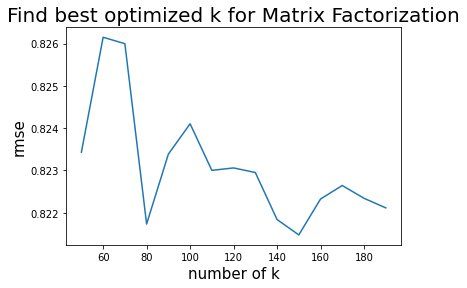

In [20]:
# 300은 0.820으로 k값이 너무 작으면 성능이 저하될 수 있음
plt.plot(res.index, res.rmse)
plt.title("Find best optimized k for Matrix Factorization", fontsize=20)
plt.xlabel('number of k', fontsize=15)
plt.ylabel('rmse', fontsize=15)
plt.show()

## Part 2. Matrix Factorization with Simple Python module

- https://pypi.org/project/matrix-factorization/

In [21]:
!pip install matrix-factorization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for matrix-factorization: filename=matrix_factorization-1.3-py3-none-any.whl size=16467 sha256=ba7f571a22745400714a6cb343ed79e9716cce5bf13a69c3020b8f5789207e05
  Stored in directory: /root/.cache/pip/wheels/f6/34/7b/11dd792f060e9c2d7230855147d3bfadbd2b6bbcf5132dcbbc
Successfully built matrix-factorization


In [23]:
from matrix_factorization import BaselineModel, KernelMF, train_update_test_split

In [24]:
# 각자 작업 환경에 맞는 경로를 지정해주세요. Google Colab과 Jupyter환경에서 경로가 다를 수 있습니다.
path = '/content/drive/MyDrive/Colab Notebooks/recsys/data/movielens'
ratings_df = pd.read_csv(os.path.join(path, 'ratings.csv'), encoding='utf-8')

print(ratings_df.shape)
print(ratings_df.head())

(100836, 4)
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [25]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=1234)

print(train_df.shape)
print(test_df.shape)

(80668, 4)
(20168, 4)


In [26]:
train_df.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [27]:
new_train_df = train_df
new_train_df = new_train_df.rename(columns={"userId": "user_id", "movieId": "item_id"})
new_train_df.head()

,user_id,item_id,rating,timestamp
95713,600,5943,3.0,1237714356
61560,407,2571,5.0,1424349171
77204,482,8958,4.0,1105397126
93367,599,2322,2.5,1498515283
90892,590,2959,3.5,1258416553


dataset -> train, valid, test -> train, valid : 실제 학습할때 , test :  학습된 모델의 성능을 평가할 때 사용

In [28]:
(
    X_train_initial,
    y_train_initial,
    X_train_update,
    y_train_update,
    X_test_update,
    y_test_update,
) = train_update_test_split(new_train_df, frac_new_users=0.2)

In [29]:
# Initial training
matrix_fact = KernelMF(n_epochs=20, n_factors=100, verbose=1, lr=0.001, reg=0.005)
matrix_fact.fit(X_train_initial, y_train_initial)

Epoch  1 / 20  -  train_rmse: 0.9883399899698151
Epoch  2 / 20  -  train_rmse: 0.9637263556949878
Epoch  3 / 20  -  train_rmse: 0.9473238313302879
Epoch  4 / 20  -  train_rmse: 0.9349916136778332
Epoch  5 / 20  -  train_rmse: 0.9251109853486973
Epoch  6 / 20  -  train_rmse: 0.9168159881902584
Epoch  7 / 20  -  train_rmse: 0.9096428374182969
Epoch  8 / 20  -  train_rmse: 0.9032740314696017
Epoch  9 / 20  -  train_rmse: 0.8975209994859193
Epoch  10 / 20  -  train_rmse: 0.8922421087768962
Epoch  11 / 20  -  train_rmse: 0.8873493763473855
Epoch  12 / 20  -  train_rmse: 0.8827582003407594
Epoch  13 / 20  -  train_rmse: 0.8784249699081988
Epoch  14 / 20  -  train_rmse: 0.8742908236698829
Epoch  15 / 20  -  train_rmse: 0.870348134243971
Epoch  16 / 20  -  train_rmse: 0.8665700587707775
Epoch  17 / 20  -  train_rmse: 0.8629079783644007
Epoch  18 / 20  -  train_rmse: 0.8593576249551313
Epoch  19 / 20  -  train_rmse: 0.855920821903754
Epoch  20 / 20  -  train_rmse: 0.8525527556029918


KernelMF(gamma=0.01, lr=0.001, n_epochs=20, reg=0.005)

In [30]:
# Update model with new users
matrix_fact.update_users(
    X_train_update, y_train_update, lr=0.001, n_epochs=20, verbose=1
)

Epoch  1 / 20  -  train_rmse: 0.9589206475329921
Epoch  2 / 20  -  train_rmse: 0.9445194400008743
Epoch  3 / 20  -  train_rmse: 0.933477483273654
Epoch  4 / 20  -  train_rmse: 0.92464443966693
Epoch  5 / 20  -  train_rmse: 0.9174266644115897
Epoch  6 / 20  -  train_rmse: 0.911351056559611
Epoch  7 / 20  -  train_rmse: 0.9061255088925904
Epoch  8 / 20  -  train_rmse: 0.9015426415040962
Epoch  9 / 20  -  train_rmse: 0.8974705480796492
Epoch  10 / 20  -  train_rmse: 0.8938221918670283
Epoch  11 / 20  -  train_rmse: 0.8905126440784604
Epoch  12 / 20  -  train_rmse: 0.8874921149214133
Epoch  13 / 20  -  train_rmse: 0.8847178846398248
Epoch  14 / 20  -  train_rmse: 0.8821488273055678
Epoch  15 / 20  -  train_rmse: 0.8797593032607522
Epoch  16 / 20  -  train_rmse: 0.8775188887088301
Epoch  17 / 20  -  train_rmse: 0.8754209935705256
Epoch  18 / 20  -  train_rmse: 0.873436267201235
Epoch  19 / 20  -  train_rmse: 0.8715606648002128
Epoch  20 / 20  -  train_rmse: 0.8697802745047821


In [31]:
pred = matrix_fact.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared=False)
print(f"\nTest RMSE: {rmse:.4f}")


Test RMSE: 0.8929


In [32]:
# Get recommendations
user = 200
items_known = X_train_initial.query("user_id == @user")["item_id"]
matrix_fact.recommend(user=user, items_known=items_known)

,user_id,item_id,rating_pred
525,200,50,4.576351
394,200,858,4.463807
252,200,527,4.452979
1181,200,1089,4.387312
272,200,593,4.387232
590,200,260,4.376616
1155,200,2329,4.370416
1248,200,912,4.366152
330,200,48516,4.356732
906,200,1222,4.288721


### SGD

In [33]:
# train
baseline_model = BaselineModel(method='sgd', n_epochs = 20, reg = 0.005, lr = 0.01, verbose=1)
baseline_model.fit(X_train_initial, y_train_initial)

pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.9054915595928831
Epoch  2 / 20  -  train_rmse: 0.881584513845082
Epoch  3 / 20  -  train_rmse: 0.8680310530025867
Epoch  4 / 20  -  train_rmse: 0.8589571488544466
Epoch  5 / 20  -  train_rmse: 0.8514426563145863
Epoch  6 / 20  -  train_rmse: 0.8453786404752578
Epoch  7 / 20  -  train_rmse: 0.8408521343300258
Epoch  8 / 20  -  train_rmse: 0.8366095780114894
Epoch  9 / 20  -  train_rmse: 0.8328423792284239
Epoch  10 / 20  -  train_rmse: 0.8295523055696276
Epoch  11 / 20  -  train_rmse: 0.8270778076895169
Epoch  12 / 20  -  train_rmse: 0.8244264041586135
Epoch  13 / 20  -  train_rmse: 0.8220480298902726
Epoch  14 / 20  -  train_rmse: 0.820138685249549
Epoch  15 / 20  -  train_rmse: 0.8183021927208851
Epoch  16 / 20  -  train_rmse: 0.8165368874523515
Epoch  17 / 20  -  train_rmse: 0.8148054657100612
Epoch  18 / 20  -  train_rmse: 0.8130951452461217
Epoch  19 / 20  -  train_rmse: 0.8119069560623652
Epoch  20 / 20  -  train_rmse: 0.8108013218078723

Test RMSE:

In [34]:
# update
%%time
baseline_model.update_users(X_train_update, y_train_update, n_epochs=20, lr=0.001, verbose=1)
pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.9252707670598469
Epoch  2 / 20  -  train_rmse: 0.9113143320522687
Epoch  3 / 20  -  train_rmse: 0.9008639873079556
Epoch  4 / 20  -  train_rmse: 0.8927885915642819
Epoch  5 / 20  -  train_rmse: 0.8862616001955554
Epoch  6 / 20  -  train_rmse: 0.8809494505299377
Epoch  7 / 20  -  train_rmse: 0.8764982702640991
Epoch  8 / 20  -  train_rmse: 0.8727082368200215
Epoch  9 / 20  -  train_rmse: 0.8694581929300514
Epoch  10 / 20  -  train_rmse: 0.866633233421161
Epoch  11 / 20  -  train_rmse: 0.8641681528648704
Epoch  12 / 20  -  train_rmse: 0.8619933906546304
Epoch  13 / 20  -  train_rmse: 0.8600558009508458
Epoch  14 / 20  -  train_rmse: 0.8583232449844312
Epoch  15 / 20  -  train_rmse: 0.8567810002390268
Epoch  16 / 20  -  train_rmse: 0.855397374191611
Epoch  17 / 20  -  train_rmse: 0.8541459678247463
Epoch  18 / 20  -  train_rmse: 0.8530121325810716
Epoch  19 / 20  -  train_rmse: 0.8519850164547319
Epoch  20 / 20  -  train_rmse: 0.8510467904536199

Test RMSE:

### ALS

In [35]:
# train
baseline_model = BaselineModel(method='als', n_epochs = 20, reg = 0.5, verbose=1)
baseline_model.fit(X_train_initial, y_train_initial)

pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.7964847297108067
Epoch  2 / 20  -  train_rmse: 0.7806708359460365
Epoch  3 / 20  -  train_rmse: 0.7793186406104425
Epoch  4 / 20  -  train_rmse: 0.7791102771481131
Epoch  5 / 20  -  train_rmse: 0.7790549241213646
Epoch  6 / 20  -  train_rmse: 0.7790306315911192
Epoch  7 / 20  -  train_rmse: 0.7790146898414732
Epoch  8 / 20  -  train_rmse: 0.7790017849541463
Epoch  9 / 20  -  train_rmse: 0.7789904920302883
Epoch  10 / 20  -  train_rmse: 0.7789803556195163
Epoch  11 / 20  -  train_rmse: 0.77897118058964
Epoch  12 / 20  -  train_rmse: 0.7789628496676174
Epoch  13 / 20  -  train_rmse: 0.7789552739964462
Epoch  14 / 20  -  train_rmse: 0.7789483786698248
Epoch  15 / 20  -  train_rmse: 0.7789420978957702
Epoch  16 / 20  -  train_rmse: 0.7789363729896431
Epoch  17 / 20  -  train_rmse: 0.7789311512851246
Epoch  18 / 20  -  train_rmse: 0.7789263853905251
Epoch  19 / 20  -  train_rmse: 0.7789220326040879
Epoch  20 / 20  -  train_rmse: 0.7789180544202791

Test RMSE:

In [36]:
# update
%%time
baseline_model.update_users(X_train_update, y_train_update, n_epochs=20, lr=0.001, verbose=1)
pred = baseline_model.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.9304149535962924
Epoch  2 / 20  -  train_rmse: 0.9181399173688781
Epoch  3 / 20  -  train_rmse: 0.9090193857012581
Epoch  4 / 20  -  train_rmse: 0.9019474719096187
Epoch  5 / 20  -  train_rmse: 0.8963124541644445
Epoch  6 / 20  -  train_rmse: 0.8917396977660179
Epoch  7 / 20  -  train_rmse: 0.8879105298703373
Epoch  8 / 20  -  train_rmse: 0.8846789703590081
Epoch  9 / 20  -  train_rmse: 0.8818732572993563
Epoch  10 / 20  -  train_rmse: 0.8794674319386958
Epoch  11 / 20  -  train_rmse: 0.8773484754328428
Epoch  12 / 20  -  train_rmse: 0.875496156665143
Epoch  13 / 20  -  train_rmse: 0.8738516875330271
Epoch  14 / 20  -  train_rmse: 0.8723989322886643
Epoch  15 / 20  -  train_rmse: 0.8710875356547693
Epoch  16 / 20  -  train_rmse: 0.8699224595829258
Epoch  17 / 20  -  train_rmse: 0.8688630331985132
Epoch  18 / 20  -  train_rmse: 0.867894290751489
Epoch  19 / 20  -  train_rmse: 0.867010782035355
Epoch  20 / 20  -  train_rmse: 0.8662117557812049

Test RMSE: 